# Implement the Clean algorithm using a fully padded array
---

In [1]:
import sys
import os

dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.notebook import tqdm
from scipy.optimize import minimize

In [3]:
from lib.FT_modelling import *
from lib.formatter import * 
from lib.conversions import *
from lib.photometry import *

In [4]:
pupil = pupil_from_fits("pupil.fits")

In [5]:
# Define simulation parameters

aperture = 0.018 # 18mm
m2_obsc = 0 # m
wl = 525e-9 # 525nm - Central green band on RBP cam
fl = 0.15 # 15cm camera lens
npix = 512 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
tf_size = 2**10 # 1024
x = 0 # On-axis star (pixel units)
y = 0 # On-axis star (pixel units)
margs = [pupil, aperture, m2_obsc, npix, wl, fl, pix_size, tf_size]

In [6]:
# Create a model m, PSF on a grid twice the size of the data image
m_PSF = FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, tf_size, x, y)

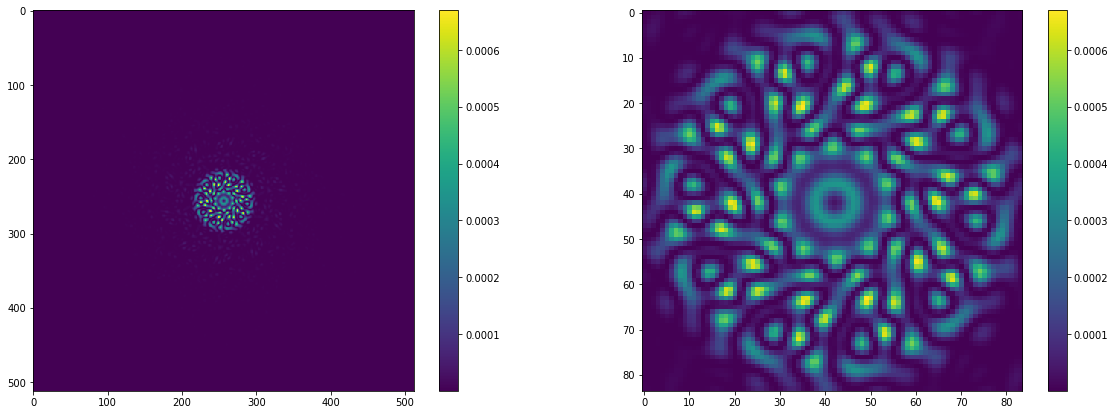

In [8]:
s = 42
c = npix//2
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(m_PSF)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(m_PSF[c-s:c+s, c-s:c+s])
plt.colorbar()
plt.show()

In [11]:
auto_corr = correlate(m_PSF, m_PSF)

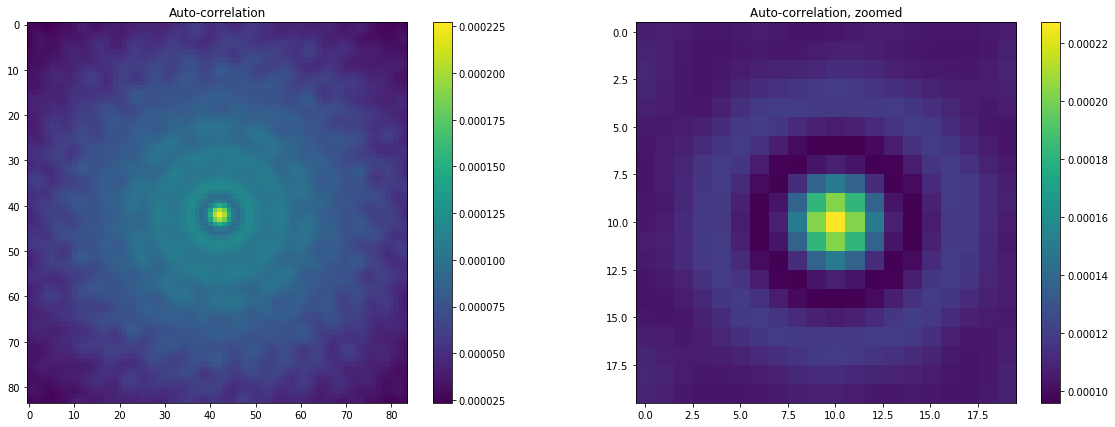

In [12]:
plt.figure(figsize=(20,7))
s2 = 10

plt.subplot(1,2,1)
plt.title("Auto-correlation")
plt.imshow(auto_corr[c-s:c+s, c-s:c+s])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Auto-correlation, zoomed")
plt.imshow(auto_corr[c-s2:c+s2, c-s2:c+s2])
plt.colorbar()

plt.savefig("images/auto_correlation_regular")
plt.show()

---
### Get the flux-correlation value relationship

The flux correlation value relationship is linear and is demonstrated to be so in the CLEAN.ipynb doccument

In [13]:
# Determine the correlation-flux relationship
S = 1/np.max(auto_corr)
print(S)

4400.77790380229


---
## Simulate single star, on-axis, no detector or photon noise

In [14]:
# Define image paramters

n_stars = 1
fluxes_in = [1e6]
coords_in = np.array([[0, 0]])

In [15]:
data = np.zeros([npix, npix])
for i in range(n_stars):
    data += fluxes_in[i]*FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, 
                                  tf_size, coords_in[i, 0], coords_in[i, 1], polar=False)
# Keep a copy of the original data point so we can work on the "im" variable
im = deepcopy(data)

In [16]:
# Get correlation peaks
C = correlate(im, m_PSF)
pos, peak = get_max(C)
print(pos, peak)

[0 0] 227.23255339379793


---
## Simulate multiple randomised stars shifted by integer values, no detector or photon noise, all equal flux, no PSFs over the edge

In [17]:
# Define image paramters

n_stars = 6
fluxes_in = 1e6 * np.ones(n_stars)
# coords_in = np.array([[-npix//2, -npix//2], [-npix//2, -npix//2]])

# Seed for reproducibility
np.random.seed(0)

# Shift the coordianted by this amount ot prevent the PSFs going over the edge of the detector
edge_oset = 60
t_range = npix - 2*edge_oset # total range
p_range = [-t_range//2, t_range//2]# range of positions values
coords_in = np.random.randint(p_range[0], p_range[1], size=[n_stars, 2])

print(coords_in)

[[ -24 -149]
 [ -79   -4]
 [ 127   55]
 [  -1  163]
 [-187   15]
 [  81   46]]


In [18]:
data = np.zeros([npix, npix])
for i in range(n_stars):
    data += fluxes_in[i]*FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, 
                                  tf_size, coords_in[i, 0], coords_in[i, 1], polar=False)
# Keep a copy of the original data point so we can work on the "im" variable
im = deepcopy(data)

In [19]:
C = correlate(im, m_PSF)
p1, peak1 = get_max(C)

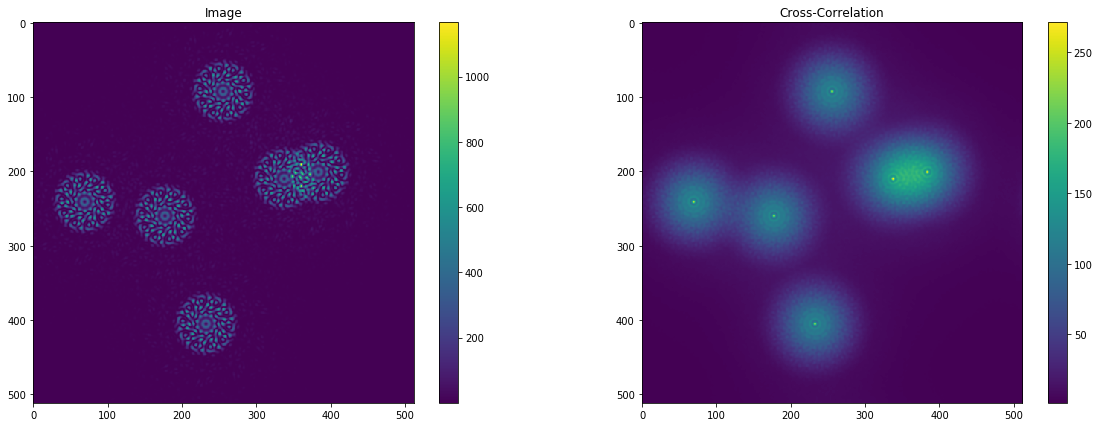

In [20]:
plt.figure(figsize=(20,7))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(im)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Cross-Correlation")
plt.imshow(C)
plt.colorbar()

plt.show()

---
## Test the clean algorithm on this data

In [21]:
im_out = deepcopy(data)
positions = []
fluxes = []
sub_im = np.zeros(im_out.shape)
for i in tqdm(range(100)):
    im_out, pos, flux, PSF = clean(im_out, m_PSF, S, margs)
    sub_im += PSF
    positions.append(pos)
    fluxes.append(flux)
    
stars = reconstruct_stars(positions, fluxes)
for star in stars:
    print(star[0], star[1]/1e6)


[-187   15] 0.6024024647025379
[-79  -4] 0.5710145446894721
[ -24 -149] 0.569215691235355
[ -1 163] 0.5951800887010992
[81 46] 0.6477961325314701
[127  55] 0.6473444450001911


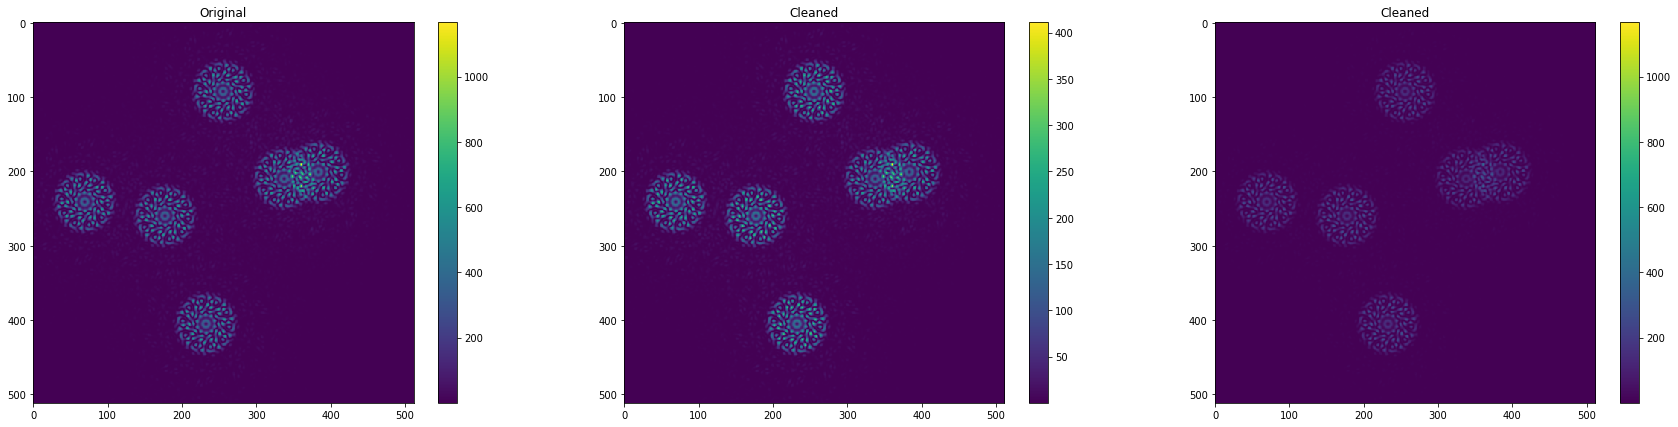

In [22]:
plt.figure(figsize=(30,7))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(data)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Cleaned")
# plt.imshow(im_out, vmax=np.max(data))
plt.imshow(im_out)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Cleaned")
plt.imshow(im_out, vmax=np.max(data))
# plt.imshow(im_out)
plt.colorbar()

plt.show()

Now that we have this working in the simplest non-trivial case we test the implementing of the algorithm on non-integer shifted pixel values using the gaussian dsitribution found in the sub_pixel_correlation notebook

---

## Sub pixel information extraction using gaussian fits

In [23]:
# def fit_gaussian(inputs):
#     data, gparams = inputs
    
#     print(data, gparams)
    
#     model = gaussian(gparams)
#     diff = np.sum((data-model)**2)
#     return diff

# def gaussian(gparams):
#     x0, y0, peak  = gparams
#     ampl_ratio, sig, p = np.load("fit_values.npy")
    
#     A = peak*ampl_ratio
#     xs = np.linspace(-1, 1, num=3)
#     X, Y = np.meshgrid(xs, xs)
    
#     xcomp = ((x0-X)**2)/(2*sig**2)
#     ycomp = ((y0-Y)**2)/(2*sig**2)
#     expo = (xcomp + ycomp)**p
#     y = A*np.exp(-expo)
    
#     return y

In [24]:
p, peak = get_max(C, raw=True)
win_size = 11 # size of window we take minimum from
s = win_size//2
window = C[p[0]-s:p[0]+s+1, p[1]-s:p[1]+s+1]
bground = np.min(window)
subbed = C-bground

In [25]:
window.shape

(11, 11)

In [26]:
def model(theta, amplitude, sigma, power, X, Y):
    """ Here's our 2d gaussian model """
    x0, y0 = theta
    exponent = ((x0-X)**2/(2*sigma**2) + (y0-Y)**2/(2*sigma**2))**power
    z = amplitude * np.exp(-exponent)
    return z

def lnprior(theta):
    """ Here's where we define bounds for our model - the prior"""
    x0, y0 = theta
    if x0 > -1.5 and x0 < 1.5 and y0 > -1.5 and y0 < 1.5:
        return 0.
    return -np.inf

def lnlike(theta, amplitude, sigma, power, X, Y, z):
    """ Here's the log likelihood """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    z_model = model(theta, amplitude, sigma, power, X, Y)
    return lp + (-0.5 * np.sum((z - z_model) ** 2))

""" I alias the log likelihood to be negative, so i can use a minimizer on it"""
nll = lambda *args: -lnlike(*args)

def find_centre(cmap, p):
    """
    
    """
    
    # Window the peak
    win_size = 11 # size of window we take minimum from, depends on optical paramters (npix etc)
    s = win_size//2
    window = cmap[p[0]-s:p[0]+s+1, p[1]-s:p[1]+s+1]
        
    # Subract to background
    bground = np.min(window)
    subbed = window-bground
    ampl = np.max(subbed)
    
    # Nomralise peak to 1
    im = subbed/ampl
#     im = im*100
    
    # Fitting paramters
    start = [0, 0] # intitalise at the centre
    
    # Load and set other paramters (maybe hardcode for efficiency later)
    ampl_ratio, sig, power = np.load("fit_values.npy")
    ampl_in = ampl*ampl_ratio
    xs = np.linspace(0, win_size, num=win_size, endpoint=False) - s
    X, Y = np.meshgrid(xs, xs)
    args = (ampl_in, sig, power, X, Y, im)
    
    # Initialise fit
    res = minimize(nll, start, args=args)
    
    # Raise error if our positional fit fails
#     If this happens we need to fix the model that we fit with
#     if res["success"] == False:
#         print(res)
#         raise Exception("Positional model fitting failed, uh oh.")
    
    # Get out values for output
    # Figure out which way around this should be by testing
    x, y = res['x']
    offset = [x, -y]
    # Note: the reason to use -y in this case is becuase we are feeding this offest value into 
    # the coordiante system used by the FT modelling code which defines y in the oppoite way 
    # to the way arrays are indexed in python, hence the negative
    
#     return offset
    return offset, res
    
def clean(im, m, ma_val, margs, shave=0.05):
    """
    im: data image
    m: model
    ma_val: model auto correlation value
    
    """
    # Get correlation map and values
    cmap = correlate(im, m)
    p, peak = get_max(cmap, raw=True)
    pos = idx_to_pos(p, cmap.shape[0])
    
    # Find the true centre
#     offset = find_centre(cmap, p)
    offset, res = find_centre(cmap, p)
    # NOTE BE CAREFUL OF THE COORDINATE CHANGE HERE
    # p is in array coordiante
    # pos is in fourier modelling coordinates
    p_in = pos + offset
    
    # Shave and flux values
    flux = shave*peak*ma_val
    
    # Generate psf
    pupil, aperture, m2_obsc, npix, wl, fl, pix_size, tf_size = margs
    PSF = flux*FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, 
                                  tf_size, p_in[0], p_in[1], polar=False)
    
    # Generate output image and return object
    im_out = im - PSF    
    return im_out, pos, flux, PSF, res

---

# Now the true test, non integer positonal shifts

In [27]:
# Define image paramters

n_stars = 6
fluxes_in = 1e6 * np.ones(n_stars)
# coords_in = np.array([[-npix//2, -npix//2], [-npix//2, -npix//2]])

# Seed for reproducibility
np.random.seed(2)

# Shift the coordianted by this amount ot prevent the PSFs going over the edge of the detector
edge_oset = 60
t_range = npix - 2*edge_oset # total range
# p_range = [-t_range//2, t_range//2]# range of positions values
# coords_in = np.random.randint(p_range[0], p_range[1], size=[n_stars, 2])
coords_in = t_range * (np.random.rand(n_stars, 2) - 0.5)

print(coords_in)

[[ -25.08999836 -185.83691712]
 [  19.46769133  -25.35362209]
 [ -31.21582158  -66.50875017]
 [-115.77773546   46.75421881]
 [ -78.53536792  -91.40370816]
 [  47.48446245   11.42370096]]


In [28]:
data = np.zeros([npix, npix])
for i in range(n_stars):
    data += fluxes_in[i]*FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, 
                                  tf_size, coords_in[i, 0], coords_in[i, 1], polar=False)
# Keep a copy of the original data point so we can work on the "im" variable
im = deepcopy(data)

In [29]:
im_out = deepcopy(data)
positions = []
fluxes = []
reses = []
sub_im = np.zeros(im_out.shape)
for i in tqdm(range(100)):
#     im_out, pos, flux, PSF = clean(im_out, m, S, margs)
    im_out, pos, flux, PSF, res = clean(im_out, m_PSF, S, margs)
    sub_im += PSF
    positions.append(pos)
    fluxes.append(flux)
    reses.append(res)
    
stars = reconstruct_stars(positions, fluxes)
for star in stars:
    print(star[0], star[1]/1e6)


[-116   47] 0.5652943836220744
[-79 -92] 0.3191670098135207
[-79 -91] 0.18939653280000085
[-78 -92] 0.04458353637674016
[-78 -91] 0.08046086183163387
[-31 -67] 0.3138140837491064
[-31 -66] 0.3490924541158147
[ -25 -186] 0.5828901864997393
[ 19 -26] 0.1897186680939413
[ 19 -25] 0.2484806943746949
[ 20 -25] 0.24654673516630993
[47 11] 0.1575379055066092
[47 12] 0.11736443808507528
[48 11] 0.3369076381610035
[48 12] 0.036686580676975056


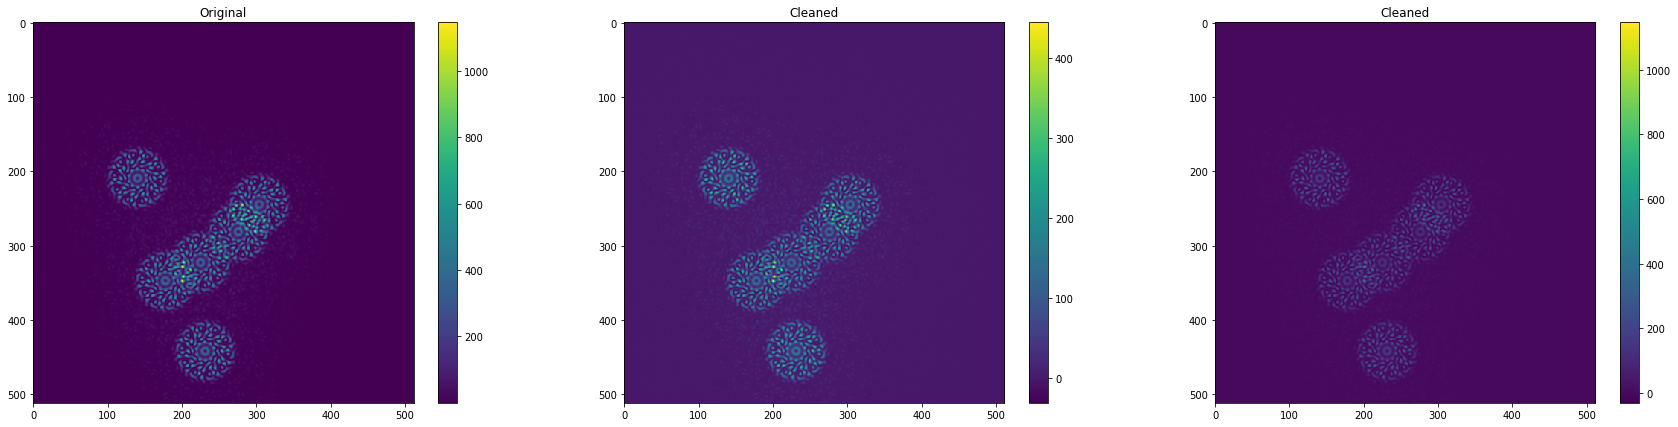

In [30]:
plt.figure(figsize=(30,7))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(data)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Cleaned")
# plt.imshow(im_out, vmax=np.max(data))
plt.imshow(im_out)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Cleaned")
plt.imshow(im_out, vmax=np.max(data))
# plt.imshow(im_out)
plt.colorbar()

plt.show()

In [124]:
messages = []
count = 0
for res in reses:
    if res['success'] != True:
        messages.append(res['message'])
        count += 1

In [125]:
count

30

In [126]:
for m in messages:
    print(m)

Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Desired 